# SETUP

###Acquire the dataset from kaggle. 
Know how to download data from kaggle: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

Visit the dataset: https://www.kaggle.com/hooong/ngafid-mc-20210917?select=NGAFID_MC_C37.csv

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hooong/ngafid-mc-20210917

In [ ]:
!unzip /content/ngafid-mc-20210917.zip

In [ ]:
#solve the dataset will be changed after the training process

import pandas as pd 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib as plt
import seaborn as sns
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None

In [ ]:
#TPU

import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# HYPER

In [ ]:
BASE_SEQ_LEN = 1000
NUM_VAR = 31
INPUT_SEQ_LEN = 32 
OUTPUT_SEQ_LEN = 1 
BATCH_SIZE = 128

# READ DATA

In [ ]:
#start from 2 to 12
df = {}
for i in range(2,13):
  url = 'https:' + '//raw.githubusercontent.com/Rainmaker519/NGAFID_Anomaly_Detection/main/NGAFID_dataset/c172_file_' + str(i)+ '.csv'
  df[i] = pd.read_csv(url)


In [ ]:
df[2].describe()

In [ ]:
#cut the dataset to 1000 in the mid point
df_final = {}
for i in df.keys():
  df_final[i] = df[i][(int(len(df[i])/2)-499):(int(len(df[i])/2)+501)]

In [ ]:
df_final[2].head()

In [ ]:
def df_to_np_array(df): 
    """ This function will turn the dataframe to numpy array
    Parameter: dataframe
    Return: Numpy array
    """
    examples = []
    examples.append(df.iloc[:, :].values)
    
    return np.stack(examples)

def get_slice_random_segment(length):
    """This function will acquire a length of slice from the dataset.
    Parameter: length, length of the dataset
    return: array
    """
    def slice_random_segment(x):
      """This function will return the specific array
      Parameter: x, dataset
      return: array
      """
      #minval = min numbers of data points, maxval = max numbers of data points
      start = tf.random.uniform(shape=[], minval=0, maxval= BASE_SEQ_LEN-length, dtype=tf.int64)
      x = x[start:start+length]
      print(x)
      #reshape will turn x into the shape of (length, NUM_VAR)
      x = tf.reshape(x, (length, NUM_VAR))
      print(x)
      return x 
    return slice_random_segment

def get_split_xy(y_length):
  """This will get two specific group of data points.
  Parameter: y_length
  return: x, y 
  """
  def split_xy(x):
    """
    Parameter: dataset
    """
    y = x[-y_length:]
    return x[:-y_length], y 
  return split_xy

def get_dataset(train_data, shuffle = False, repeat = False): 
    train_data = df_to_np_array(train_data)
    ds = tf.data.Dataset.from_tensor_slices(train_data)
    ds = ds.map(get_slice_random_segment(length = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN))
    ds = ds.map(get_split_xy(y_length=OUTPUT_SEQ_LEN))

    #Changing the value of buffer_size affects how uniform the shuffling
    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds.repeat(2)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    return ds 

  
def get_detection_xy(df , scaler):
    """get the testing dataset
    Parameter: dataset, number of simulation run, the scaler you use in the training process
    return: x:slice of dataset(testing), y:target value
    """
    
    scaled = scaler.transform(df.iloc[:, :])

    x = []
    y = []

    for i in range(BASE_SEQ_LEN - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN):
        x.append(scaled[i:i+ INPUT_SEQ_LEN])
        y.append(scaled[i+INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])

    x = np.stack(x)
    y = np.stack(y)

    return x,y 
    
    
def get_mse(model, df, scaler):
    """ Get loss value: the mean squared error value
    Parameter: dataset, simulation run, model
    Return: loss value
    """
    x, y = get_detection_xy(df, scaler) 
    y_pred_1 = model.predict(x, verbose = True)
    mse_1 = tfk.losses.MSE(y, y_pred_1).numpy()
    return mse_1.flatten()

In [ ]:
def train_model(df, model):
  """This function is to tain the model
  Parameter: df, model
  Return: trained model, and trained scaler
  """
  train_df = df[:]


  scaler = preprocessing.MinMaxScaler()
  scaler.fit(train_df.iloc[:, :].values)

  train_df.iloc[:, :] = scaler.transform(train_df.iloc[:, :].values)
  train_ds = get_dataset(train_df, shuffle = True, repeat=True)

  model.fit(
      train_ds, 
      epochs = 20,
      steps_per_epoch = 1000,
  )

  return model, scaler

In [36]:
def get_result( model, data, baseline, scaler):
  """This function is to get and plot the result
  Paramter: baseline, simrun, trained model, and trained scaler
  """

  mse_model_1 = get_mse(model, data, scaler)
  # pd.DataFrame({'normal' : mse_model_1, 'baseline': baseline}).plot(ylim = (0.0, 0.02))
  return mse_model_1

# MODEL

In [ ]:
#LSTM
def get_rnn_model_final():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.LSTM(64, return_sequences=False),
                              tfkl.Dropout(0.5),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [ ]:
#CNN
def get_cnn_model_final():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(128, 15, 9,activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

# Train the model

In [40]:
model_rnn = get_rnn_model_final()
model_rnn, scaler_rnn = train_model(df_final[2] ,model_rnn)

Tensor("strided_slice:0", shape=(None, 31), dtype=float64)
Tensor("Reshape:0", shape=(33, 31), dtype=float64)
Epoch 1/20
1000/1000 [==============================] - 45s 36ms/step - loss: 0.0728
Epoch 2/20
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0288
Epoch 3/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0125
Epoch 4/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0099
Epoch 5/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0084
Epoch 6/20
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0073
Epoch 7/20
1000/1000 [==============================] - 33s 34ms/step - loss: 0.0064
Epoch 8/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0059
Epoch 9/20
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0053
Epoch 10/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0049
Epoch 11/20
1000/1000 [================

In [ ]:
model_rnn.summary()

In [ ]:
model_cnn = get_cnn_model_final()
model_cnn, scaler_cnn = train_model(df_final[2] ,model_cnn)

In [ ]:
model_cnn.summary()

# Get the result

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3657c46250>,
      dtype=object)

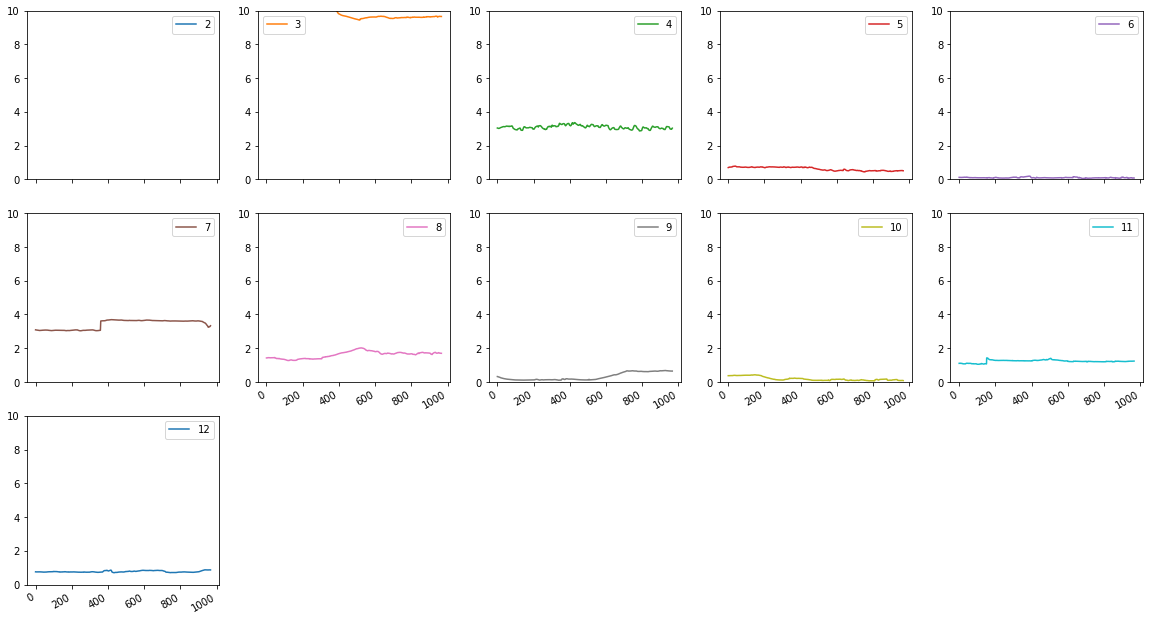

In [44]:
# baseline = 0.01
# # models = [model_rnn, model_cnn]

# final_result = {}
# for i in df.keys():
#   temp = get_result(model_rnn, df_final[i], baseline, scaler)
#   final_result[i] = temp

# df_loss = pd.DataFrame(final_result)
df_loss.plot(subplots = True, figsize = (20,20), ylim = (0.0, 10.0), layout= (5,5))